## Data Pipeline
---

In [1]:
import time
import pandas as pd
start_time = time.time()

In [2]:
# # Load EDGAR files
# import pickle

# df = pd.read_csv('datasets/table_companies_short.csv',sep=',', index_col=0)
# tickers = list(df['ticker'])
# df.head()

# import lxml.html.clean 
# data_dict = {}
# for i, t in enumerate(tickers):
#     with open("reports/" + t + ".txt", "rb") as file:
#         data_dict[t] = lxml.html.clean.clean_html(pickle.load(file))

In [30]:
files = !ls AnnualReports/*.txt

In [4]:
#files = files[0:60]

In [5]:
# Load ANNUAL REPORTS files


import lxml.html.clean 
data_dict = {}
for i, t in enumerate(files):
    with open(t , "r") as file:
        data_dict[t] = lxml.html.clean.clean_html(file.read())

In [6]:
#data_dict[files[0]]

In [7]:
# Financial stopwords
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
stopwordsfile = "dictionaries/financial_stopwrods.txt"
file = open(stopwordsfile, "r")
financial_stop_words = file.read().split('\n')
stopwords = []
stopwords.extend(english_stop_words)
stopwords.extend(financial_stop_words)
stopwords = list(set(stopwords))

In [8]:
#print(data_dict['AXLX'][0:600])
#print(data_dict[files[0]])

In [9]:
# Data cleaning process
from text_cleaning import *

data_dict = clean_data_dict(data_dict, stopwords)

In [10]:
# Dict to pandas
data = pd.DataFrame\
    .from_dict({k: [v] for k, v in data_dict.items()})\
    .transpose()\
    .sort_index()\
    .rename(columns = {0:'report'})

In [11]:
# Calculate text scores and financial sentiment
from sentiment_scores import *

positive_words = read_dictionary('dictionaries/positive_words.txt')
negative_words = read_dictionary('dictionaries/negative_words.txt')
uncertainty_dict = read_dictionary('dictionaries/uncertainty_dictionary.txt')
constraining_dict = read_dictionary('dictionaries/constraining_dictionary.txt')

In [12]:
# Similarity to Gold standard
from nltk.tokenize import word_tokenize, sent_tokenize

gold_standard = 'AnnualReports/ABN_AMRO_Group_(2018).pdf.txt'
#gold_standard = 'AnnualReportsTest/ABN_AMRO_Group_(2018).pdf.txt'
gold_standard_tokens = word_tokenize(data_dict[gold_standard])

data['cosine_similarity'] = calculate_cosine(data_dict, gold_standard_tokens)
data['entropy_similarity'] = calculate_entropy(data_dict, gold_standard_tokens)

In [13]:
# Absolute scores
data['count_tokens'] = data.report.apply(total_word_count)
data['unique_tokens'] = [data.loc[i].to_numpy().nonzero()[0].size for i in data.index]
data['percentage_complex_word'] = data.report.apply(percentage_complex_word)
data['positive_score'] = data.report.apply(lambda x: generate_score(x, positive_words))
data['negative_score'] = data.report.apply(lambda x: generate_score(x, negative_words))
data['uncertainty_score'] = data.report.apply(lambda x: generate_score(x, uncertainty_dict))
data['constraining_score'] = data.report.apply(lambda x: generate_score(x, constraining_dict))

In [14]:
# Relative scores
data['prop_of_average'] = [round(i/data.count_tokens.mean(),2) for i in data.count_tokens]
data['relative_unique'] = [relative_score(x, y)*10 for x, y in zip(data.unique_tokens, data.count_tokens)]
data['relative_positive'] = [relative_score(x, y)*10 for x, y in zip(data.positive_score, data.count_tokens)]
data['relative_negative'] = [relative_score(x, y)*10 for x, y in zip(data.negative_score, data.count_tokens)]
data['relative_uncertainty'] = [relative_score(x, y)*10 for x, y in zip(data.uncertainty_score, data.count_tokens)]
data['relative_constraining'] = [relative_score(x, y)*10 for x, y in zip(data.constraining_score, data.count_tokens)]
data['fog_index'] = [calculate_fog_index(x, y) for x, y in zip(data.count_tokens, data.percentage_complex_word)]
data['distance_average'] = [round(i/data.count_tokens.mean(),2) for i in data.count_tokens]

In [15]:
# Keywords scores
from flashtext import KeywordProcessor

kp_risk_words = KeywordProcessor()
kp_risk_words.add_keywords_from_list(["risk", "loss"])
data['risk_loss'] = [len(kp_risk_words.extract_keywords(data.loc[i,'report'])) for i in data.index]
data['relative_risk'] = [relative_score(x, y)*100 for x, y in zip(data.risk_loss, data.count_tokens)]

kp_clean_words = KeywordProcessor()
kp_clean_words.add_keywords_from_list(["responsibility", "green energy", "renewable"])
data['green_words'] = [len(kp_clean_words.extract_keywords(data.loc[i,'report'])) for i in data.index]
data['relative_green'] = [relative_score(x, y)*100 for x, y in zip(data.green_words, data.count_tokens)]

In [16]:
data.head()

,report,cosine_similarity,entropy_similarity,count_tokens,unique_tokens,percentage_complex_word,positive_score,negative_score,uncertainty_score,constraining_score,...,relative_positive,relative_negative,relative_uncertainty,relative_constraining,fog_index,distance_average,risk_loss,relative_risk,green_words,relative_green
AnnualReports/ABN_AMRO_Group_(2018).pdf.txt,abn amro bank abn amro ntable contents nabout ...,0.0,0.280923,73443,3,0.289136,340,1095,1476,420,...,0.046,0.149,0.201,0.057,29377.316,1.69,1243,1.69,21,0.03
AnnualReports/AGNC_Investment_(2018).pdf.txt,providing private capital housing market ninve...,0.0,0.280923,30689,3,0.255629,172,440,789,177,...,0.056,0.143,0.257,0.058,12275.702,0.71,319,1.04,4,0.01
AnnualReports/A_G_Barr_(2018).pdf.txt,barr nannual accounts njanuary bru ninnovation...,0.0,0.280923,31277,3,0.309109,377,270,338,162,...,0.121,0.086,0.108,0.052,12510.924,0.72,147,0.47,15,0.05
AnnualReports/Aboitiz_Power_(2018).pdf.txt,scanned camscanner sheet full name registratio...,0.0,0.280923,39717,3,0.295188,111,238,323,91,...,0.028,0.060,0.081,0.023,15886.918,0.91,113,0.28,76,0.19
AnnualReports/Acer_(2018).pdf.txt,acer incorported npublication date april name ...,0.0,0.280923,64150,3,0.299548,472,1107,524,353,...,0.074,0.173,0.082,0.055,25660.120,1.48,767,1.20,49,0.08


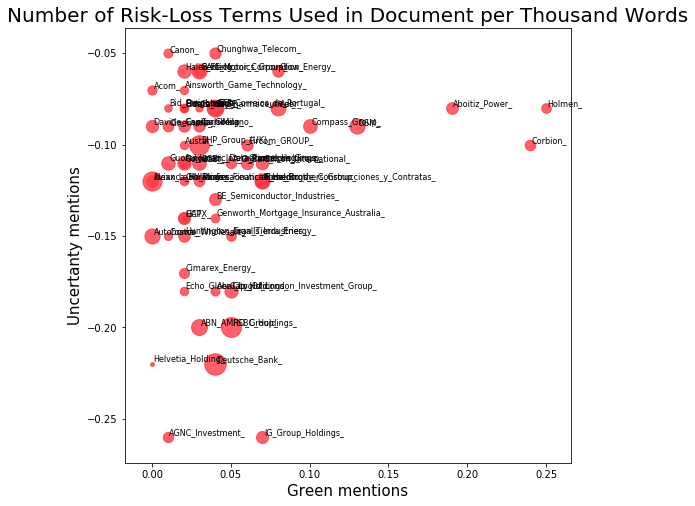

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 8]

for i, company in enumerate(data.index):
    x = round(data.relative_green.loc[company],2)
    y = - round(data.relative_uncertainty.loc[company],2)
    s = round(data.distance_average.loc[company],2)
    plt.scatter(x, y, color='#FF3844', alpha=.8, s=s*150)
    plt.text(x+0.001, y+0.001, data.index[i][14:-14], fontsize=8)
    
plt.title('Number of Risk-Loss Terms Used in Document per Thousand Words', fontsize=20)
plt.xlabel('Green mentions', fontsize=15)
plt.ylabel('Uncertanty mentions', fontsize=15)
#plt.savefig('risk_loss.png')
plt.show()

In [18]:
data.columns

Index(['report', 'cosine_similarity', 'entropy_similarity', 'count_tokens',
       'unique_tokens', 'percentage_complex_word', 'positive_score',
       'negative_score', 'uncertainty_score', 'constraining_score',
       'prop_of_average', 'relative_unique', 'relative_positive',
       'relative_negative', 'relative_uncertainty', 'relative_constraining',
       'fog_index', 'distance_average', 'risk_loss', 'relative_risk',
       'green_words', 'relative_green'],
      dtype='object')

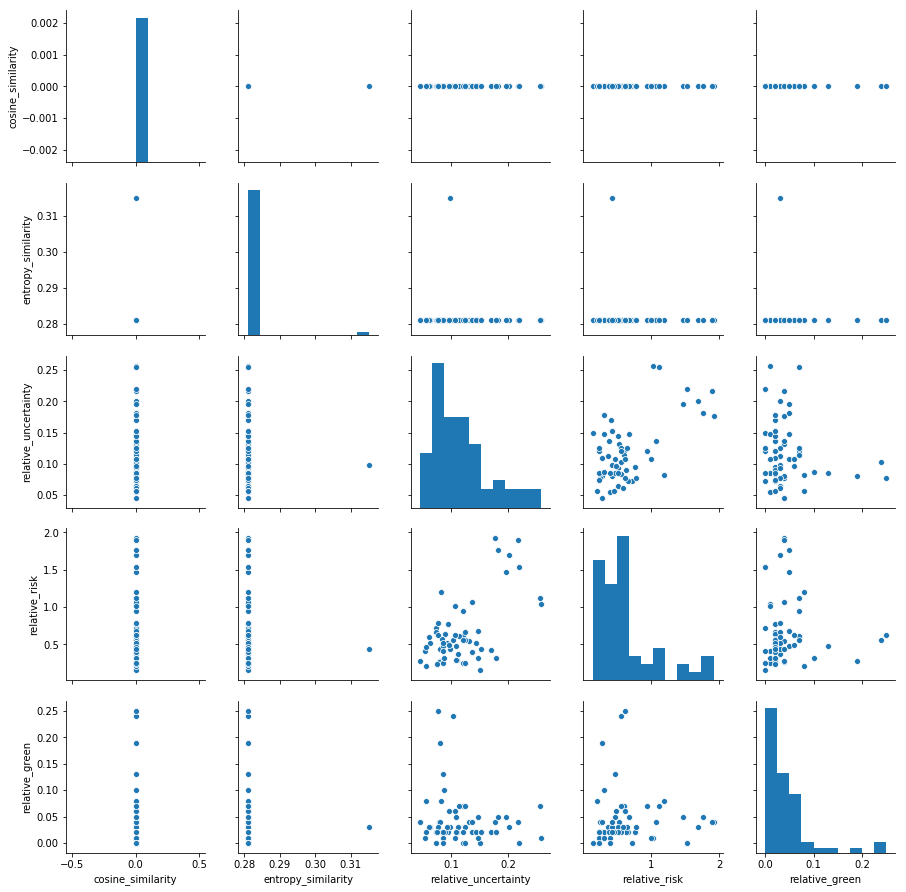

In [19]:
import seaborn as sns

features = ['cosine_similarity','entropy_similarity','relative_uncertainty','relative_risk','relative_green']
#sns.pairplot(data.drop(columns=['report']))
sns.pairplot(data[features])

In [20]:
data = data.sort_values(['relative_green','relative_positive','entropy_similarity'], ascending=False)

In [21]:
data['invest'] = [1 if i < data.relative_risk.median() else 0 for i in data.relative_uncertainty]

In [22]:
data.head()

,report,cosine_similarity,entropy_similarity,count_tokens,unique_tokens,percentage_complex_word,positive_score,negative_score,uncertainty_score,constraining_score,...,relative_negative,relative_uncertainty,relative_constraining,fog_index,distance_average,risk_loss,relative_risk,green_words,relative_green,invest
AnnualReports/Holmen_(2018).pdf.txt,forest npaperboard npaper nwood products nrene...,0.0,0.280923,26971,3,0.246042,239,344,207,112,...,0.128,0.077,0.042,10788.498,0.62,166,0.62,68,0.25,1
AnnualReports/Corbion_(2018).pdf.txt,annual nkeep creating ncorbion contact ncontac...,0.0,0.280923,32753,3,0.294935,288,393,336,196,...,0.120,0.103,0.060,13101.318,0.75,182,0.56,80,0.24,1
AnnualReports/Aboitiz_Power_(2018).pdf.txt,scanned camscanner sheet full name registratio...,0.0,0.280923,39717,3,0.295188,111,238,323,91,...,0.060,0.081,0.023,15886.918,0.91,113,0.28,76,0.19,1
AnnualReports/DSM_(2018).pdf.txt,royal dsm integrated nannual glance nnutrition...,0.0,0.280923,67126,3,0.264130,637,623,576,210,...,0.093,0.086,0.031,26850.506,1.54,322,0.48,88,0.13,1
AnnualReports/Compass_Group_(2018).pdf.txt,annual nfocus nperformance people purpose nas ...,0.0,0.280923,54983,3,0.291563,552,391,479,417,...,0.071,0.087,0.076,21993.317,1.26,177,0.32,54,0.10,1


In [23]:
data.drop(columns=['report']).to_csv('data_short.csv')

In [24]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, xgboost, numpy, textblob, string

In [25]:
# Importing the dataset
X = data.loc[:, ['relative_green','relative_positive','entropy_similarity']].values
y = data.loc[:,'invest'].values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [26]:
def train_model(classifier, feature_vector_train, label, feature_vector_test, label_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    return metrics.accuracy_score(predictions, label_test)

In [27]:
accuracy = train_model(ensemble.RandomForestClassifier(), X_train, y_train, X_test, y_test)
print ("RF, Selected variables: {}".format(accuracy))

RF, Selected variables: 1.0


/Users/pedrohserrano/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [28]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 439.59447503089905 seconds ---


In [29]:
# --- 88.29133796691895 seconds -- Testfolder